In [1]:
import os
import pandas as pd
import numpy as np
import json
import pickle
from pprint import pprint
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from src.data import load_source, slice_d
from src.config import Config, get_option_fallback
from src.path import get_best_model_paths, get_exp_paths, get_report_path, load_json, load_rep_cfg
from knowledge_tracing.trainer import Trainer

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
projectdir = Path('/code')
assert projectdir.exists()

In [3]:
experiment_name = '20_0218_edm2020_assistments09'
expsoutdir = projectdir / 'output' / experiment_name

cp_rp_paths = []
for expdir in sorted(expsoutdir.iterdir()):
    # Checkpoints
    cpdir = expdir / 'checkpoints'
    lastcpdir = sorted(cpdir.iterdir())[-1]
    bestcp_path = sorted(lastcpdir.iterdir())[-1]
    print(bestcp_path)
    # Report
    rpdir = expdir / 'report'
    lastrpdir = sorted(rpdir.iterdir())[-1]
    rp_path = next(lastrpdir.glob('*.json'))
    print(rp_path)
    cp_rp_paths.append((bestcp_path, rp_path))
    
# Asteria
configdics = []
for checkpoint_path, report_path in cp_rp_paths:
    with open(report_path, 'r') as f:
        report = json.load(f)
        config_dic = report['config']
        config_dic['load_model'] = str(checkpoint_path)
        configdics.append(config_dic)
        
def get_simu_res(config_dic):
    config = Config(config_dic, projectdir)
    config.batch_size = 1
    trainer = Trainer(config)
    
    trainer.evaluate_model()


    seq_size = config.sequence_size
    simu = [[0]*i + [1]*(seq_size - i) for i in range(seq_size+1)]

    simu_res = dict()
    for v in range(config.n_skills):
        xs = []
        preds = []
        for s in simu:
            res = trainer.model.loss_batch(
                torch.Tensor([(v,a) for a in s]).unsqueeze(0),
                torch.Tensor([(v,a) for a in s]).unsqueeze(0),
                torch.BoolTensor([True]*seq_size).unsqueeze(0),)
            preds.append(res['pred_prob'][-1].item())
            xs.append(sum(s))
        simu_res[v] = (xs, preds)
    return simu_res


simures_list = []
for config_dic in configdics:
    simu_res = get_simu_res(config_dic)
    simures_list.append(simu_res)
    

base_res = None
descres_list = []
for simu_res in simures_list:
    if base_res is None:
        base_res = {k:v for k, v in sorted(simu_res.items(), key=lambda it: it[1][1][0] - it[1][1][-1])}
    else:
        desc_res = {k:simu_res[k] for k in base_res.keys()}
        descres_list.append(desc_res)

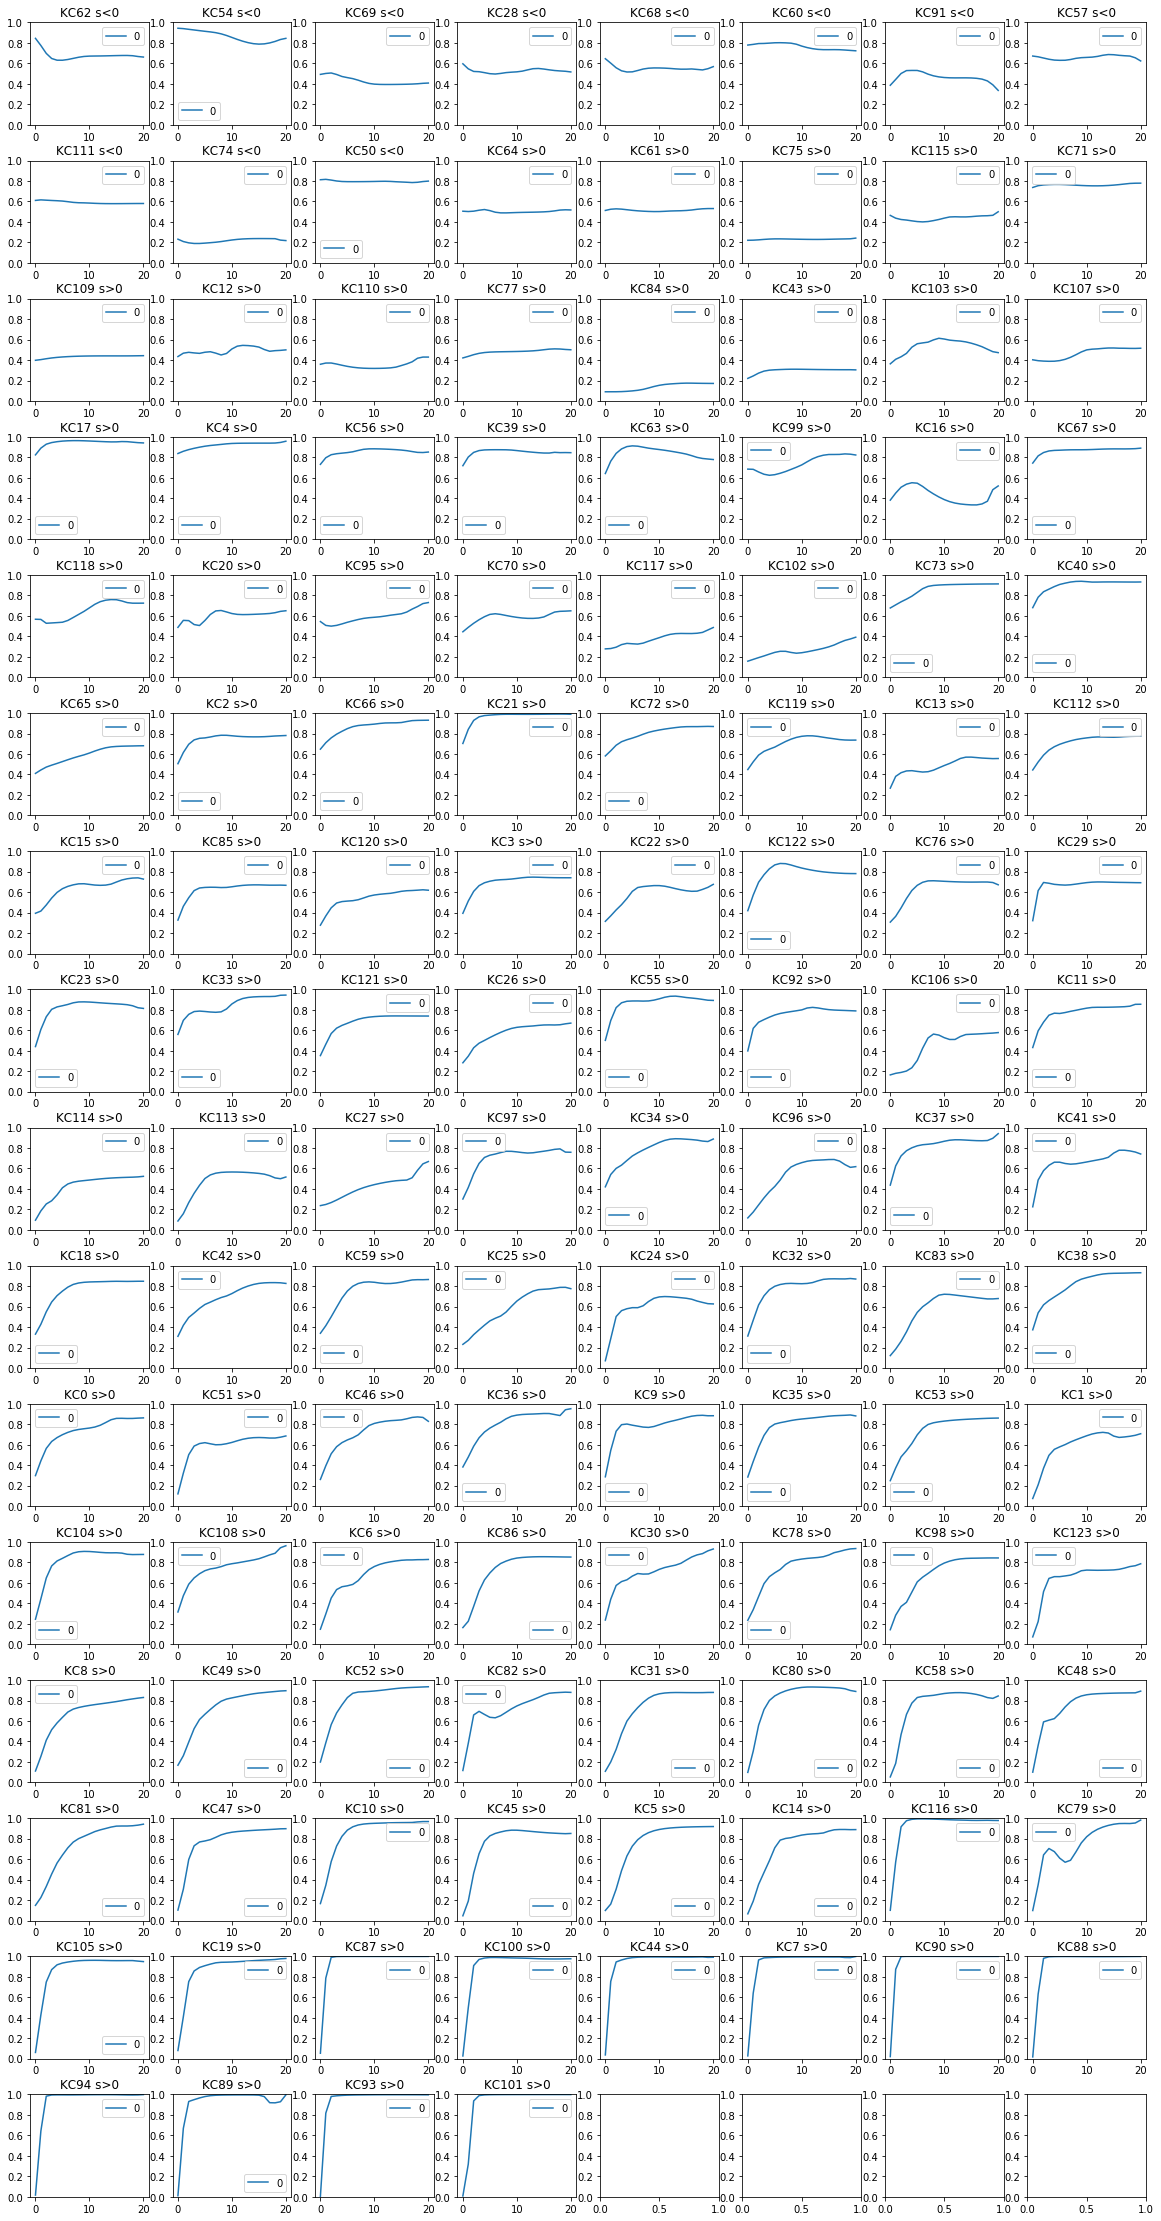

In [4]:
        
h, w = (124+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]<sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='0', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
ax.legend()
plt.show()

# Learning curve for `20_0220_edm2020_asmt15`

In [43]:
config_name = '20_0220_edm2020_asmt15'
report_dicts = [load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)]
report_dicts = sorted(report_dicts, key=lambda r: r['config']['sequence_size'])
[r['config']['exp_name'] for r in report_dicts]

['sequence_size15padTrue.auto',
 'sequence_size15padFalse.auto',
 'sequence_size20padFalse.auto',
 'sequence_size20padTrue.auto',
 'sequence_size30padFalse.auto',
 'sequence_size30padTrue.auto',
 'sequence_size40padFalse.auto',
 'sequence_size40padTrue.auto',
 'sequence_size50padFalse.auto',
 'sequence_size50padTrue.auto',
 'sequence_size100padFalse.auto',
 'sequence_size100padTrue.auto']

In [44]:
def show_learning_curve(name, jack_up, idclist_dic, idc='eval_auc'):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x = np.transpose(np.array(list(idclist_dic['epoch'].values())))
    x = idclist_dic['epoch']['0'] * 5
    x = [i+jack_up for i in x]
    y = []
    for _y in idclist_dic[idc].values():
        y += _y
#         ax.plot(x, y, label=k.replace('_', ' '))
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)
#     ax.legend()
#     ax.set_ylim(0., 1.)
#     plt.savefig(outdir / f'{config.model_name}_lc.png')

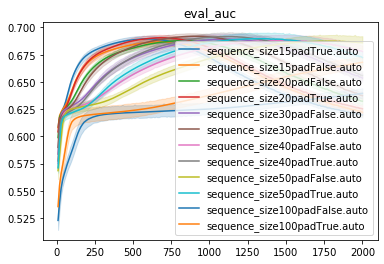

In [45]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'])
plt.show()

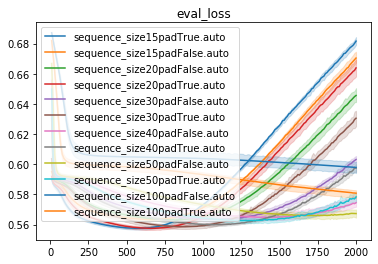

In [46]:
for r in report_dicts:
    show_learning_curve(r['config']['exp_name'], 0, r['indicator'], idc='eval_loss')
plt.show()

# Test auc for `20_0220_edm2020_asmt15`

In [47]:
def summarize_test_res(rep):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([f for f in rep['best']['auc_epoch'].values()])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([f[0] for f in rep['indicator']['test_auc'].values()])
    print(f'AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}')
    print()

In [48]:
for r in report_dicts:
    summarize_test_res(r)

sequence_size15padTrue.auto:	Best epoch at  600.0±14.1 	AUC: 69.0746±0.1098

sequence_size15padFalse.auto:	Best epoch at  694.0±8.9  	AUC: 68.7875±0.1249

sequence_size20padFalse.auto:	Best epoch at  836.0±31.3 	AUC: 68.8453±0.1469

sequence_size20padTrue.auto:	Best epoch at  686.0±33.6 	AUC: 69.1648±0.1259

sequence_size30padFalse.auto:	Best epoch at 1114.0±32.9 	AUC: 68.7813±0.1722

sequence_size30padTrue.auto:	Best epoch at  908.0±40.2 	AUC: 69.0504±0.1534

sequence_size40padFalse.auto:	Best epoch at 1482.0±76.0 	AUC: 68.3842±0.1075

sequence_size40padTrue.auto:	Best epoch at 1112.0±35.6 	AUC: 68.8973±0.0900

sequence_size50padFalse.auto:	Best epoch at 1776.0±68.0 	AUC: 68.5738±0.2209

sequence_size50padTrue.auto:	Best epoch at 1340.0±100.2	AUC: 68.8355±0.1611

sequence_size100padFalse.auto:	Best epoch at 2000.0±0.0  	AUC: 64.0471±0.3785

sequence_size100padTrue.auto:	Best epoch at 2000.0±0.0  	AUC: 66.3083±0.2184

